## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [2]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 10.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-py3-none-any.whl size=138891 sha256=e11f0b13ad2f3bc339f53ea74ca6bc6f8e6ba45535359b23a27b17bfbc5af494
  Stored in directory: /home/dinoboy22/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to

In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [6]:
ticker = '247540.KS' 
df = yf.download(ticker, start="2021-01-01", end="2024-10-01")
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2021-01-04  43822.871094  46614.296875  42884.164062  46243.753906   
2021-01-05  45897.914062  46935.433594  45082.718750  45897.914062   
2021-01-06  46219.050781  46268.457031  44613.363281  45181.531250   
2021-01-07  45774.398438  46194.347656  45181.531250  45848.507812   
2021-01-08  46910.730469  48911.660156  46219.050781  47923.546875   

               Adj Close   Volume  
Date                               
2021-01-04  45950.343750  3367266  
2021-01-05  45606.699219  1729471  
2021-01-06  44894.859375  1432105  
2021-01-07  45557.609375  1033001  
2021-01-08  47619.480469  2154754  


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [7]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [8]:
df.reset_index(inplace=True)

1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

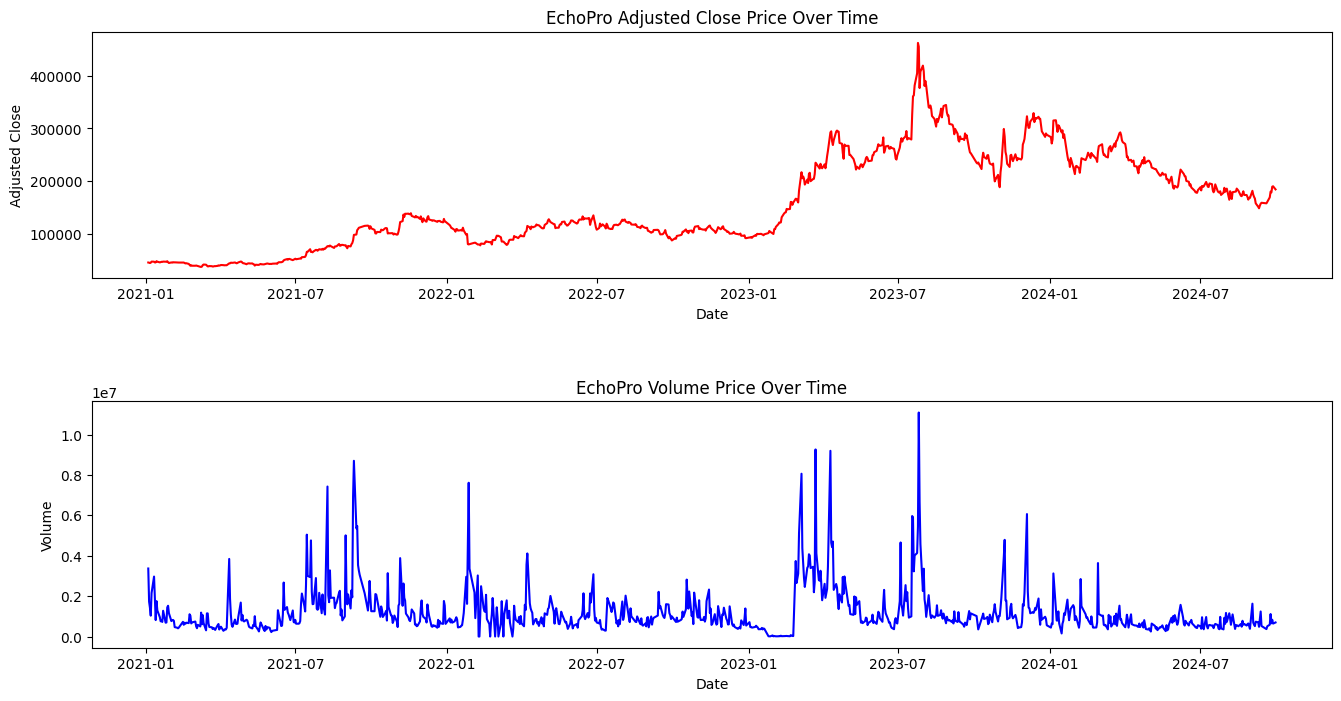

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

ax1.plot(df['Date'], df['Adj Close'], color='red')
ax2.plot(df['Date'], df['Volume'], color='blue')

ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close')
ax1.set_title('EchoPro Adjusted Close Price Over Time')
ax2.set_xlabel('Date')

ax2.set_ylabel('Volume')
ax2.set_title('EchoPro Volume Price Over Time')

plt.subplots_adjust(hspace=0.5)
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

Adjusted Price의 경우에는 2023년은 기점으로 급격하게 올랐다가 떨어지는 추세이고,
Volume Price는 2023년에 큰 변동성을 보임.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

시계열 데이터의 **정상성(stationarity)**은 데이터의 통계적 속성(평균, 분산, 자기상관 등)이 시간에 따라 일정하게 유지되는 것을 의미합니다. 다시 말해, 시간의 흐름에 따라 데이터의 분포나 특성이 변하지 않는 상태를 말합니다. 정상성은 시계열 분석에서 중요한 개념이며, 대부분의 통계적 시계열 모델(예: ARIMA 모델, 회귀 분석 등)은 정상성을 가정합니다.

정상성의 세 가지 주요 유형:
평균의 정상성: 시간에 관계없이 데이터의 평균이 일정하게 유지됩니다.
분산의 정상성: 데이터의 분산이 시간에 따라 일정하며 변동폭이 안정적입니다.
공분산의 정상성: 서로 다른 시점 간의 공분산이 시점의 차이에만 의존하고, 절대적인 시점에는 의존하지 않습니다.
정상성 검증의 필요성:
많은 시계열 모델은 데이터를 기반으로 미래를 예측하는데, 데이터가 정상성을 가지지 않는다면 모델이 잘못된 가정을 바탕으로 구축될 수 있습니다.
비정상성 데이터를 그대로 사용하면 회귀 계수가 과대평가되거나, 통계적 추론이 신뢰할 수 없게 됩니다. 정상성을 확인하고 필요하다면 정상화하는 과정은 신뢰할 수 있는 분석을 위해 필수적입니다.
정상성 검증 방법:
정상성을 확인하기 위한 대표적인 방법은 다음과 같습니다.

시각적 검사: 시계열 데이터의 그래프를 통해 평균과 분산의 변화 여부를 시각적으로 판단할 수 있습니다.
ADF (Augmented Dickey-Fuller) 검정: 통계적으로 정상성을 검정하는 방법으로, 시계열 데이터에 단위근(unit root)이 존재하는지 확인합니다. p-value가 낮으면 정상성 가설을 받아들입니다.
KPSS (Kwiatkowski-Phillips-Schmidt-Shin) 검정: ADF 검정과 반대로 정상성을 귀무가설로 두고 검정합니다. p-value가 높으면 정상성을 만족한다고 할 수 있습니다.
비정상성의 해결 방법:
비정상 시계열 데이터는 여러 방법을 통해 정상화할 수 있습니다.

차분(differencing): 시계열 데이터의 인접한 관측값들 간의 차이를 계산하여 데이터의 비정상성을 제거하는 방법입니다. 1차 차분이 일반적으로 많이 사용되며, 필요한 경우 더 높은 차수로 차분을 수행할 수 있습니다.

로그 변환(log transformation): 데이터의 변동폭이 클 경우 로그 변환을 통해 분산을 안정화시킬 수 있습니다.

선형 추세 제거(detrending): 데이터에 명확한 추세(trend)가 있을 때, 해당 추세를 제거하여 정상성을 얻을 수 있습니다.

변동성 안정화(Box-Cox 변환 등): 비정상성을 유발하는 변동성을 줄이기 위해 다양한 변환 기법을 사용할 수 있습니다.

요약:
정상성은 시계열 데이터의 평균, 분산, 공분산이 시간에 따라 일정하게 유지되는 것을 의미하며, 시계열 모델의 적합성을 보장하기 위해 필수적입니다. ADF 검정과 KPSS 검정을 통해 정상성을 검토하고, 차분, 로그 변환, 추세 제거 등의 방법으로 비정상성을 해결할 수 있습니다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [13]:
adf_result = adfuller(df['Adj Close'])

adf_statistic = adf_result[0]
p_value = adf_result[1]

print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")

ADF Statistic: -1.7297347523748732
p-value: 0.4158610030774605


2.3 ADF Test 결과를 해석하세요.

비정상성을 가지고 있다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

ACF는 누적된 상관관계를 보여주며, 데이터의 전체적인 상관 구조를 분석하는 데 유용합니다.
PACF는 직접적인 상관관계를 측정하여, 특정 시점에서 중간 시점의 영향을 제거하고 두 시점 간의 순수한 상관성을 분석하는 데 사용됩니다.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

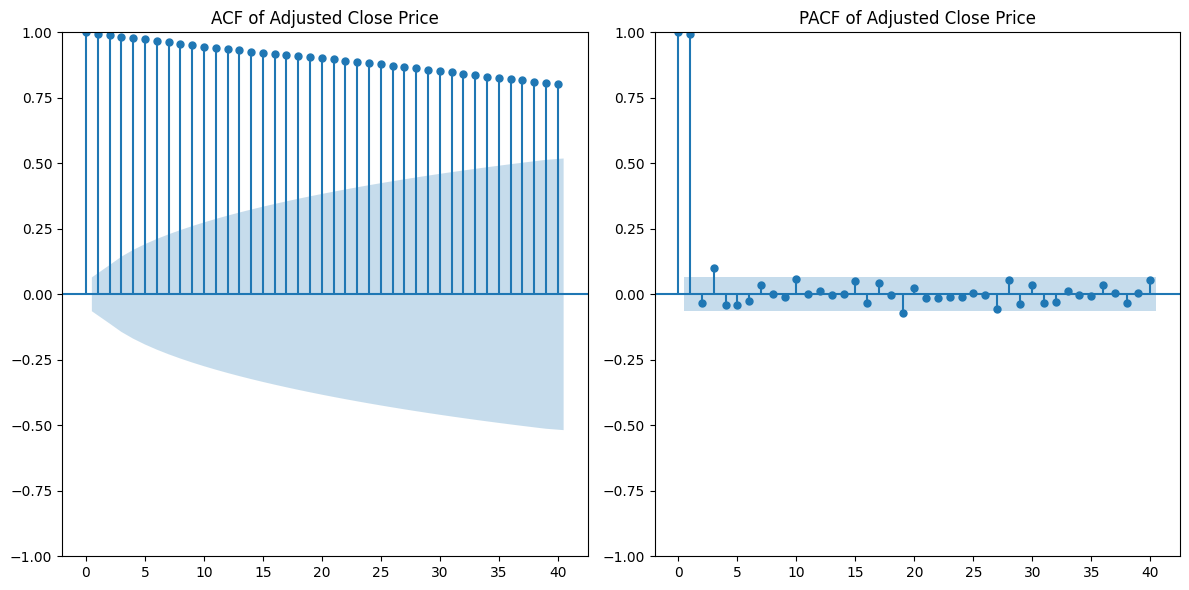

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(df['Adj Close'], ax=plt.gca(), lags=40)
plt.title('ACF of Adjusted Close Price')

plt.subplot(1, 2, 2)
plot_pacf(df['Adj Close'], ax=plt.gca(), lags=40)
plt.title('PACF of Adjusted Close Price')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

비정상성을 띠고 있는 데이터이지만, arima 모델로 돌려보면 좋을 것 같다는 결론

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

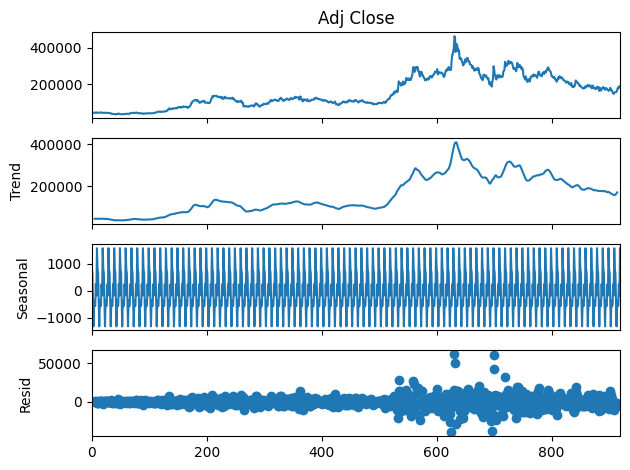

In [15]:
decomposition = seasonal_decompose(df['Adj Close'], period=10)

decomposition.plot()
plt.show()

2.8 위 결과를 해석하세요.

residual과 trend가 급격히 변동하는 시점이 비슷하다는 느낌이 있고, Seasonal 그래프는 패턴이 꽤나 반복되는 것을 알 수 있다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

연이은 관측값들의 차이를 계산해서 시계열 데이터가 정상성을 갖도록 만드는 기

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [16]:
df_diff = df['Adj Close'].diff().dropna()

adf_result_diff = adfuller(df_diff)

adf_statistic_diff = adf_result_diff[0]
p_value_diff = adf_result_diff[1]

print(f"ADF Statistic after Differencing: {adf_statistic_diff}")
print(f"p-value after Differencing: {p_value_diff}")

ADF Statistic after Differencing: -17.755490980806698
p-value after Differencing: 3.3558174813255515e-30


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

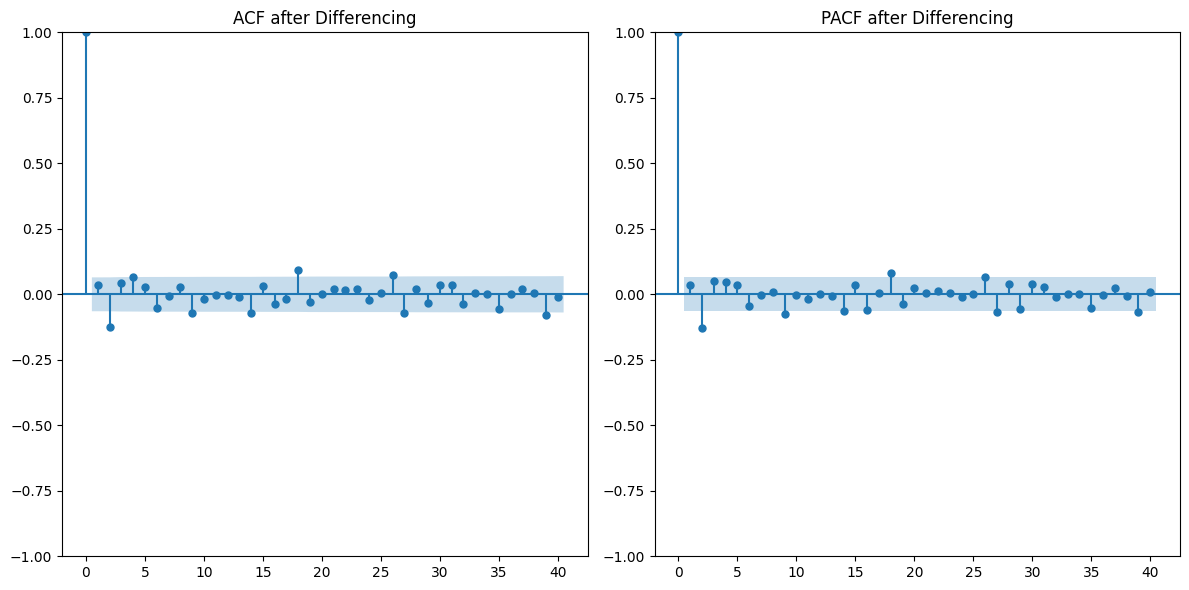

In [17]:
plt.figure(figsize=(12, 6))

# ACF 그래프
plt.subplot(1, 2, 1)
plot_acf(df_diff, ax=plt.gca(), lags=40)
plt.title('ACF after Differencing')

# PACF 그래프
plt.subplot(1, 2, 2)
plot_pacf(df_diff, ax=plt.gca(), lags=40)
plt.title('PACF after Differencing')

plt.tight_layout()
plt.show()


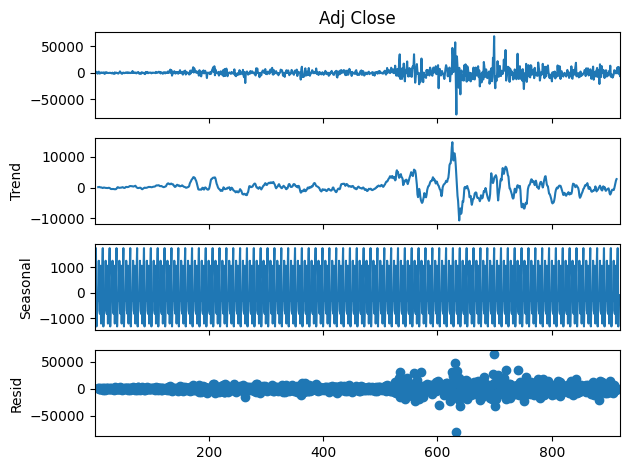

In [18]:
decomposition = seasonal_decompose(df_diff, period=12)

decomposition.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [19]:
from statsmodels.tsa.arima.model import ARIMA

In [22]:
df['Adj Close']

0       45950.343750
1       45606.699219
2       44894.859375
3       45557.609375
4       47619.480469
           ...      
915    180200.000000
916    178800.000000
917    189600.000000
918    190400.000000
919    184500.000000
Name: Adj Close, Length: 920, dtype: float64

In [23]:
model = ARIMA(df['Adj Close'], order=(3, 0, 0))  #위에서 차분을 미리 했으므로 차분 값은 0으로 설정
model_fit = model.fit()


model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  920
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -9615.490
Date:                Tue, 08 Oct 2024   AIC                          19240.979
Time:                        19:04:29   BIC                          19265.101
Sample:                             0   HQIC                         19250.184
                                - 920                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.568e+05   1.09e-09   1.43e+14      0.000    1.57e+05    1.57e+05
ar.L1          1.0363      0.016     62.914      0.000       1.004       1.069
ar.L2         -0.1647      0.024     -6.866      0.000      -0.212      -0.118
ar.L3          0.1241      0.016      7.535      0.000       0.092       0.156
sigma2      6.983e+07   2.92e-10   2.39e+17      0.000    6.98e+07    6.98e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             11970.67
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              15.64   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.34e+32. Standard errors may be unstable.
"""

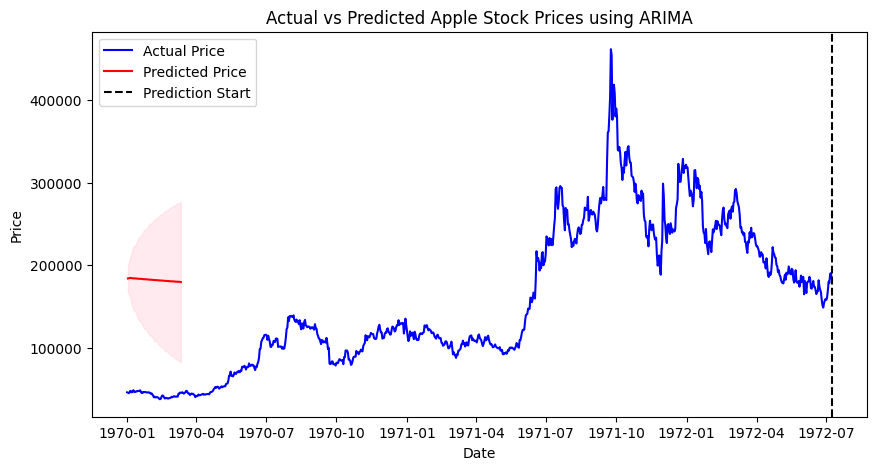

In [25]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Adj Close'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=df.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Apple Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]


[*********************100%***********************]  1 of 1 completed


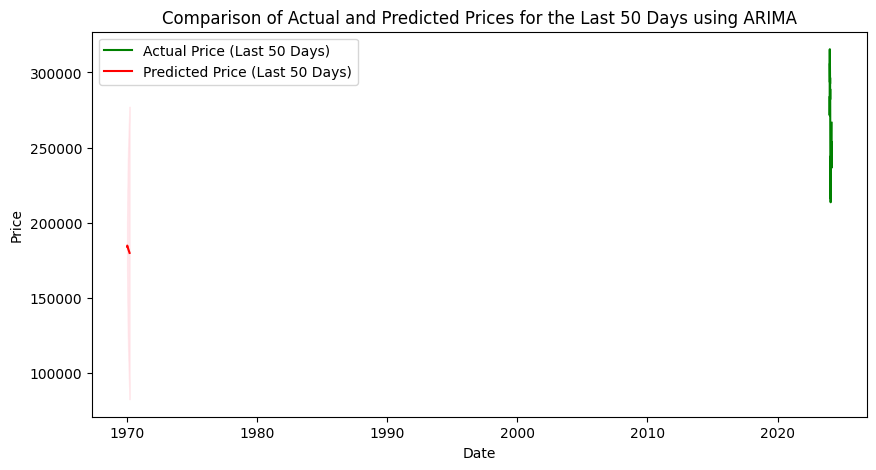

In [28]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [29]:
from prophet import Prophet

ModuleNotFoundError: No module named 'prophet'

In [31]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%%**********************]  1 of 1 completed


In [33]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

00:06:19 - cmdstanpy - INFO - Chain [1] start processing
00:06:19 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

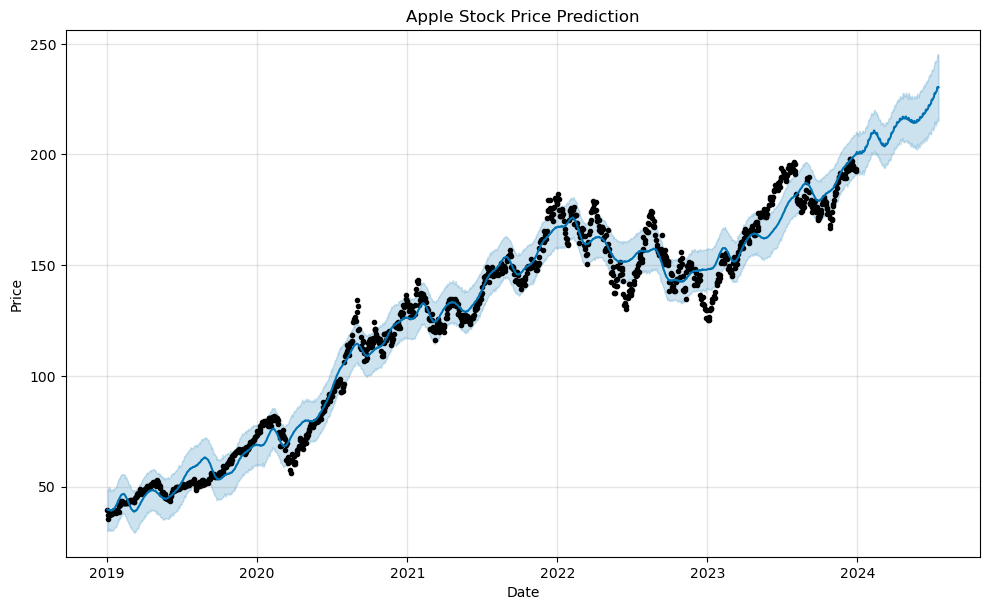

In [35]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

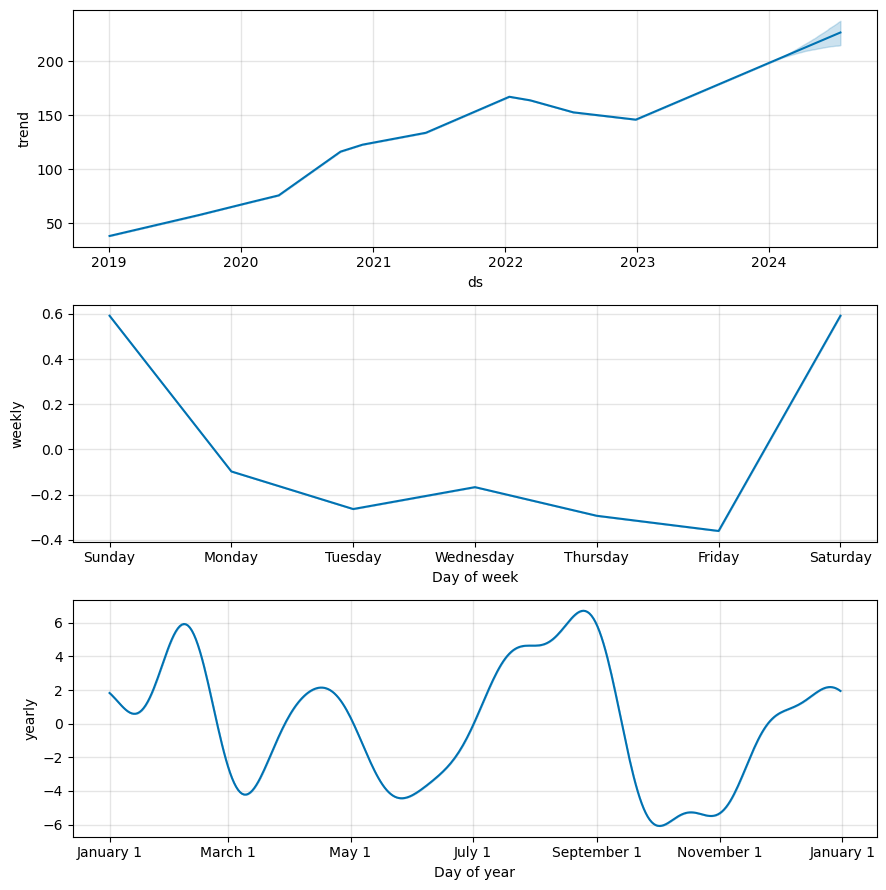

In [36]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [37]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%%**********************]  1 of 1 completed


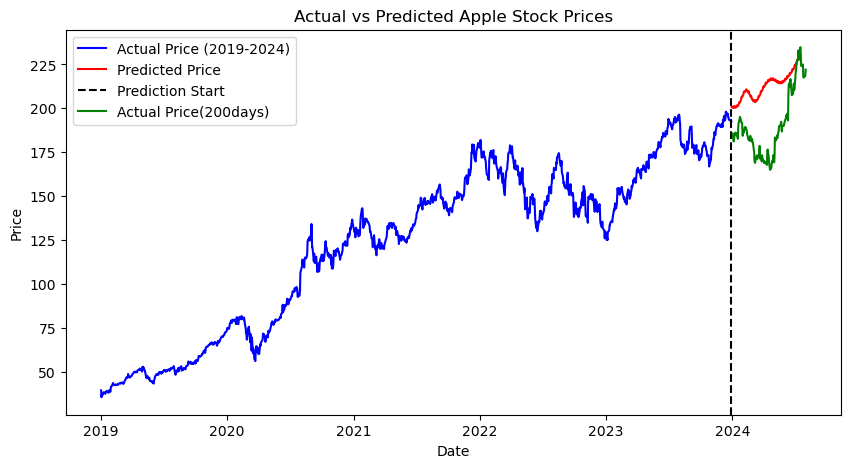

In [41]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다. 

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다. 

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.